In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import sys

import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm as _tqdm

import random
import time
import gc

from collections import defaultdict

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

EPS = float(np.finfo(np.float32).eps)

assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

from windy_gridworld import WindyGridworldEnv
from gridworld import GridworldEnv

In [2]:
# And see the results
def smooth(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

class PolicyNetwork(nn.Module):
    
    def __init__(self, num_hidden=64):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(2, num_hidden)
        self.l2 = nn.Linear(num_hidden, 4)

    def forward(self, x):
        # YOUR CODE HERE
        x = torch.relu(self.l1(x))
        x = self.l2(x)
        return torch.nn.functional.log_softmax(x, dim=0)

def select_action(model, state, epoch, grid_shape):
    # Samples an action according to the probability distribution induced by the model
    # Also returns the log_probability
    state = np.unravel_index(state, grid_shape)
    log_p = model(torch.FloatTensor(state))
    
    action = torch.multinomial(torch.exp(log_p), 1).item()
        
    return action, log_p[action]

def run_episode(env, model, epoch, grid_shape):
    # YOUR CODE HERE
    episode = []
    
    s = env.reset()
    done = False
    step = 0
    max_steps = 50
    
    while not done and step<max_steps:
        
        a, log_p = select_action(model, s, epoch, grid_shape)
        s_next, r, done, _ = env.step(a)
        
        episode.append((s, a, log_p, s_next, r))
        s = s_next
        
        step += 1
          
    env.close()
    return episode

def compute_reinforce_loss(episode, discount_factor):
    # Compute the reinforce loss
    # Make sure that your function runs in LINEAR TIME
    # Don't forget to normalize your RETURNS (not rewards)
    # Note that the rewards/returns should be maximized 
    # while the loss should be minimized so you need a - somewhere
    
    discounted_return_list = []
    log_p_list = []
    G = 0
    
    # We go over the episode and get the rewards and log_ps.
    for s, a, log_p, s_next, reward in reversed(episode):
        G = reward + discount_factor * G
        discounted_return_list.append(G)
        log_p_list.append(log_p)
    # Stacking the logs to a tensor.
    log_p_tensor = torch.stack(log_p_list)
    
    # Converting the returns to a tensor
    discounted_return_tensor = torch.FloatTensor(discounted_return_list)
    
    loss = - torch.sum(log_p_tensor * discounted_return_tensor)
    return loss

def run_episodes_policy_gradient(model, env, num_episodes, discount_factor, learn_rate, grid_shape):
    
    optimizer = optim.Adam(model.parameters(), learn_rate)
    
    episode_durations = []
    losses = []
    for i in range(num_episodes):
        
        optimizer.zero_grad()
        
        episode = run_episode(env, model, i, grid_shape)
        loss = compute_reinforce_loss(episode, discount_factor)
        
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
                           
#         if i % 10 == 0:
#             print("{2} Episode {0} finished after {1} steps"
#                   .format(i, len(episode), '\033[92m' if len(episode) <= 20 else '\033[99m'))
#             gc.collect()
          
        losses.append(loss.detach().numpy())
        episode_durations.append(len(episode))
    
        del episode
        
    return np.asanyarray(episode_durations), np.asanyarray(losses)

## REINFORCE NO BASELINE ON GRID-WORLD

Done with run 0
Done with run 1
Done with run 2
Done with run 3
Done with run 4
Done with run 5
Done with run 6
Done with run 7
Done with run 8
Done with run 9


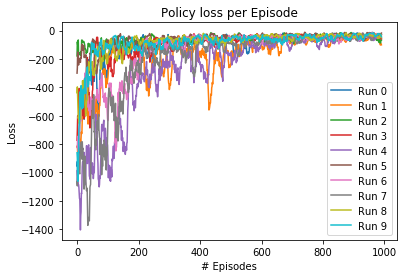

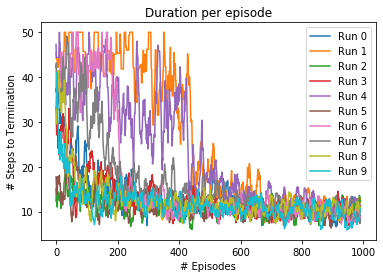

In [3]:
# Feel free to play around with the parameters!
num_runs = 10
num_episodes = 1000
discount_factor = 0.99
learn_rate = 0.001
grid_shape=[10,10]

no_episode_lenghts = []
no_policy_losses = []

env = GridworldEnv(shape=grid_shape)

for i in range(num_runs):
    
    model = PolicyNetwork()
    seed = 40 + i
    random.seed(seed)
    torch.manual_seed(seed)
    env.seed(seed)

    episode_durations_policy_gradient, losses_policy_gradient = run_episodes_policy_gradient(model,
                                                                                             env,
                                                                                             num_episodes,
                                                                                             discount_factor,
                                                                                             learn_rate,
                                                                                             grid_shape)
    no_policy_losses.append(losses_policy_gradient)
    no_episode_lenghts.append(episode_durations_policy_gradient)
    del model
    print('Done with run {}'.format(i))
    
plt.figure()
for i in range(num_runs):
    plt.plot(smooth(no_policy_losses[i], 10), label='Run {}'.format(i))
    plt.title('Policy loss per Episode')
    plt.xlabel('# Episodes')
    plt.ylabel('Loss')
    plt.legend()

plt.figure()    
for i in range(num_runs):    
    
    plt.plot(smooth(no_episode_lenghts[i],10), label='Run {}'.format(i))
    plt.title('Duration per episode')
    plt.xlabel('# Episodes')
    plt.ylabel('# Steps to Termination')
    plt.legend()

## REINFORCE LEARNED BASELINE (Value Network) ON GRID-WORLD

In [4]:
class ValueNetwork(nn.Module):
    
    def __init__(self, num_hidden=64):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(2, num_hidden)
        self.l2 = nn.Linear(num_hidden, 1)

    def forward(self, x):
        # YOUR CODE HERE
        x = torch.relu(self.l1(x))
        x = self.l2(x)
        return x

def run_episode(env, model, epoch, grid_shape):
    # YOUR CODE HERE
    episode = []
    
    s = env.reset()
    done = False
    step = 0
    max_steps = 50
    
    while not done and step<max_steps:
        
        a, log_p = select_action(model, s, epoch, grid_shape)
        s_next, r, done, _ = env.step(a)
        
        episode.append((s, a, log_p, s_next, r))
        s = s_next
        
        step += 1
          
    env.close()
    return episode

def compute_reinforce_loss_with_vNN_baseline(v_model, episode, discount_factor, grid_shape):
    # Compute the reinforce loss
    # Make sure that your function runs in LINEAR TIME
    # Don't forget to normalize your RETURNS (not rewards)
    # Note that the rewards/returns should be maximized 
    # while the loss should be minimized so you need a - somewhere
    
    discounted_return_with_baseline_list = []
    log_p_list = []
    G = 0
    
    # We go over the episode and get the rewards and log_ps.
    for s, a, log_p, s_next, reward in reversed(episode):
        G = reward + discount_factor * G
        
        state = np.unravel_index(s, grid_shape)
        baseline = v_model(torch.FloatTensor(state))
        
        discounted_return_with_baseline_list.append(G-baseline)
        log_p_list.append(log_p)
    # Stacking the logs to a tensor.
    log_p_tensor = torch.stack(log_p_list)
    
    # Converting the returns to a tensor
    discounted_return_with_baseline_tensor = torch.FloatTensor(discounted_return_with_baseline_list)
    
    loss = - torch.sum(log_p_tensor * discounted_return_with_baseline_tensor)
    return loss

def compute_value_loss(v_model, episode, discount_factor, grid_shape):
    # Compute the value loss
    returns = []
    v_estimates = []
    G = 0
    
    # We go over the episode and get the rewards and log_ps.
    for s, a, log_p, s_next, reward in reversed(episode):
        G = reward + discount_factor * G
        returns.append(G)
        
        state = np.unravel_index(s, grid_shape)
        v_estimates.append(v_model(torch.FloatTensor(state)))

    # Converting to a tensor
    v_estimates_tensor = torch.stack(v_estimates) 
    returns_tensor = torch.FloatTensor(returns)
    
    loss = torch.sum(torch.abs(returns_tensor - v_estimates_tensor))
    return loss

def run_episodes_policy_gradient_with_vNN_baseline(policy_model, v_model, env, num_episodes, discount_factor, learn_rate, grid_shape):
    
    policy_optimizer = optim.Adam(policy_model.parameters(), learn_rate)
    v_optimizer = optim.Adam(v_model.parameters(), learn_rate)
    
    episode_durations = []
    value_losses = []
    reinforce_losses = []
    for i in range(num_episodes):
        
        policy_optimizer.zero_grad()
        v_optimizer.zero_grad()
        
        episode = run_episode(env, policy_model, i, grid_shape)
        # The loss for policy network.
        reinforce_loss = compute_reinforce_loss_with_vNN_baseline(v_model, episode, discount_factor, grid_shape)
        # The loss for value network.
        value_loss = compute_value_loss(v_model, episode, discount_factor, grid_shape)
        
        reinforce_loss.backward()
        policy_optimizer.step()
        
        value_loss.backward()
        v_optimizer.step()
                           
        reinforce_losses.append(reinforce_loss.detach().numpy())
        value_losses.append(value_loss.detach().numpy())
        episode_durations.append(len(episode))
    
        del episode
        
    return np.asanyarray(episode_durations), np.asanyarray(reinforce_losses), np.asanyarray(value_losses)

Done with run 0
Done with run 1
Done with run 2
Done with run 3
Done with run 4
Done with run 5
Done with run 6
Done with run 7
Done with run 8
Done with run 9


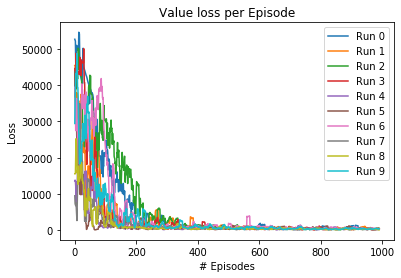

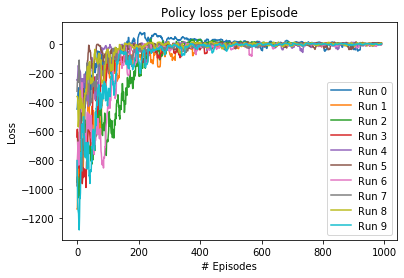

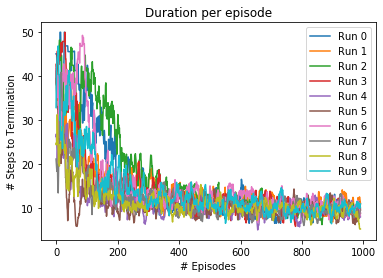

In [5]:
# Feel free to play around with the parameters!
num_runs = 10
num_episodes = 1000
discount_factor = 0.99
learn_rate = 0.001
grid_shape=[10,10]

lb_vNN_episode_lenghts = []
lb_vNN_value_losses = []
lb_vNN_policy_losses = []

env = GridworldEnv(shape=grid_shape)

for i in range(num_runs):
    
    policy_model = PolicyNetwork()
    value_model = ValueNetwork()
    seed = 40 + i
    random.seed(seed)
    torch.manual_seed(seed)
    env.seed(seed)

    episode_durations_policy_gradient, \
    policy_losses_policy_gradient, \
    value_losses_value_gradient = run_episodes_policy_gradient_with_vNN_baseline(policy_model,
                                                                                 value_model,
                                                                                 env,
                                                                                 num_episodes,
                                                                                 discount_factor,
                                                                                 learn_rate,
                                                                                 grid_shape)
    
    lb_vNN_policy_losses.append(policy_losses_policy_gradient)
    lb_vNN_value_losses.append(value_losses_value_gradient)
    lb_vNN_episode_lenghts.append(episode_durations_policy_gradient)
    
    del policy_model
    del value_model
    print('Done with run {}'.format(i))
    
    
plt.figure()
for i in range(num_runs):
    plt.plot(smooth(lb_vNN_value_losses[i], 10), label='Run {}'.format(i))
    plt.title('Value loss per Episode')
    plt.xlabel('# Episodes')
    plt.ylabel('Loss')
    plt.legend()
    
plt.figure()
for i in range(num_runs):
    plt.plot(smooth(lb_vNN_policy_losses[i], 10), label='Run {}'.format(i))
    plt.title('Policy loss per Episode')
    plt.xlabel('# Episodes')
    plt.ylabel('Loss')
    plt.legend()

plt.figure()    
for i in range(num_runs):    
    
    plt.plot(smooth(lb_vNN_episode_lenghts[i],10), label='Run {}'.format(i))
    plt.title('Duration per episode')
    plt.xlabel('# Episodes')
    plt.ylabel('# Steps to Termination')
    plt.legend()

## COMPARISON

### Policy Loss
THIS IS CURRENTLY NOT COMPARBABLE AS THE BASELINE METHOD SUBSTRACTS THE BASELINE SO THE METRICS ARE NOT THE SAME... BUT CAN BE FIXED.

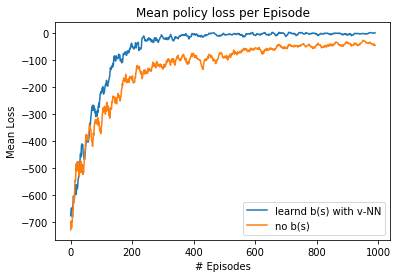

In [26]:
mean_lb_vNN_policy_losses = np.mean(lb_vNN_policy_losses, axis=0)
std_lb_vNN_policy_losses = np.std(lb_vNN_policy_losses, axis=0)

mean_no_policy_losses = np.mean(no_policy_losses, axis=0)
std_no_policy_losses = np.std(no_policy_losses, axis=0)

plt.figure()
plt.plot(smooth(mean_lb_vNN_policy_losses, 10), label='learnd b(s) with v-NN')
plt.plot(smooth(mean_no_policy_losses, 10), label='no b(s)')
plt.title('Mean policy loss per Episode')
plt.xlabel('# Episodes')
plt.ylabel('Mean Loss')
plt.legend()

### Episode Length

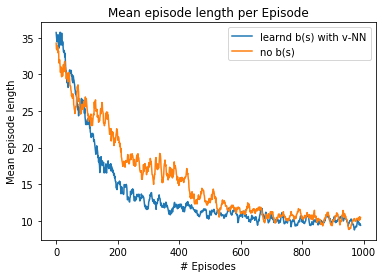

In [36]:
mean_lb_vNN_episode_lenghts = np.mean(lb_vNN_episode_lenghts, axis=0)
std_lb_vNN_episode_lenghts = np.std(lb_vNN_episode_lenghts, axis=0)

mean_no_episode_lenghts = np.mean(no_episode_lenghts, axis=0)
std_no_episode_lenghts = np.std(no_episode_lenghts, axis=0)

plt.figure()
plt.plot(smooth(mean_lb_vNN_episode_lenghts, 10), label='learnd b(s) with v-NN')
plt.plot(smooth(mean_no_episode_lenghts, 10), label='no b(s)')
plt.title('Mean episode length per Episode')
plt.xlabel('# Episodes')
plt.ylabel('Mean episode length')
plt.legend()